<a href="https://colab.research.google.com/github/Sarah0711/CUDA-Vision-Lab/blob/main/Hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Modules

In [ ]:
 %matplotlib inline
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
import random
import numpy as np 
import matplotlib.pyplot as plt 
from math import log, exp
from hyperopt import fmin, tpe, hp
import torch.nn.functional as F


#Check For Available GPU

In [ ]:
if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")
print(avDev)

cuda


#Setting Seed For Deterministic Output

In [ ]:
seed = 1
torch.manual_seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True

#Utilities For visualization

In [ ]:
def show_images(img,labels):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [ ]:
def confusion_matrix(preds, labels):
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1

   

In [ ]:
def plot_learning_curve(loss_errors):
  plt.plot(np.array(loss_errors))

In [ ]:
def plot_confusion_matrix(cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Normalized confusion matrix'
    cm = conf_matrix.numpy().astype('float') / conf_matrix.numpy().sum(axis=1)[:, np.newaxis]

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


#Load DataSets

In [ ]:

transform = transforms.Compose([      
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = dsets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = dsets.CIFAR10('./data', train=False, download=True, transform=test_transform)


0it [00:00, ?it/s]

170500096it [00:03, 48647595.31it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#Set Hyperparameters

In [ ]:
batch_size = 64
n_iters = 10000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

#Get Iteratable Data

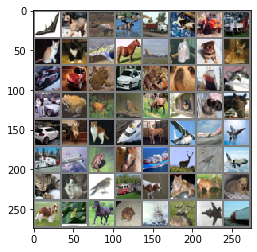

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

dataiter = train_loader.__iter__()
images, labels = dataiter.next()

show_images(torchvision.utils.make_grid(images),labels)

#Create Model Class
Sigmoid functions for hidden layers and softmax for output

In [ ]:

class LogisticRegressionModel(nn.ModuleList):
    def __init__(self, model_arch):
        super(LogisticRegressionModel, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(model_arch[i], model_arch[i+1]) for i in range(len(model_arch)-1)])
        self.sig = nn.Sigmoid()
        self.dropout =  nn.Dropout(p=0.2)
     
    def forward(self, x):
        out = x 
        for i in range(len(self.linears)-1):
            out = self.dropout(self.sig(self.linears[i](out)))
        out = self.linears[-1](out)
        return out



#Defined Loss ,Confusion Matrix

*   List item
*   List item



In [ ]:

criterion = nn.CrossEntropyLoss().to(avDev)
losses =[]

#Hinge Loss 

In [ ]:
def hingeLoss(outputs,labels):
  completeLoss = 0
  for i in range(len(labels)):
    y =labels[i]
    margins = np.maximum(0,outputs[i]-outputs[i][y]+1)
    margins[y]=0
    lossForImage = np.sum(margins)
    completeLoss+=lossForImage
  return (completeLoss/len(labels))  
  

#Softmax Loss

In [ ]:
def softmaxLoss(outputs,labels):
  completeLoss=0
 
  for i in range(len(labels)):
     #to prevent blowup
    y = labels[i]
    outputs[i] -=np.max(outputs[i])
    p = np.exp(outputs[i][y]) / np.sum(np.exp(outputs[i]))
    log_likelihood = -np.log(p)
    
    completeLoss+=log_likelihood
  return (completeLoss/len(labels))

In [ ]:
n_classes = 10
conf_matrix = torch.zeros(n_classes, n_classes)

#Train 

In [ ]:

def train(args):
  number_of_layers = args[0]
  print("Chosen Layers:", number_of_layers)
  optimizer = args[1]
  print("Chosen Optimizer:", optimizer)
  regularizer = args[2]
  print("Chosen Optimizer:", regularizer)
  input_dim = [3072]
  output_dim =[10]
  regularizer_weight = 0.9
  hidden_dims = list(number_of_layers)
  model_arch = input_dim + hidden_dims + output_dim
  model = LogisticRegressionModel(model_arch)
  model.to(avDev)
  losses.clear()
  learning_rate = 0.001
  if regularizers == 'l2':
        optimizer = optimizer(list(model.parameters()), lr=learning_rate,weight_decay=regularizer_weight )
  else:
        optimizer = optimizer(list(model.parameters()), lr=learning_rate )

  iter = 0
  
  epochs_no_improve = 0
  number_of_epoch_stop =10
  max_accuracy = 0
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.view(-1, input_dim[0]).to(avDev)
        labels = labels.to(avDev)
         
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)

        #Hinge Loss calling method
        hinge_loss = hingeLoss(outputs.detach().cpu().numpy(),labels.cpu().numpy())
        softmax_loss = softmaxLoss(outputs.detach().cpu().numpy(),labels.cpu().numpy())
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)#
       
        if regularizers == 'l1':
            l = 0
            for p in model.parameters():
              l = l + p.abs().sum()
            loss = loss + regularizer_weight * l

        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
         
        iter += 1
    losses.append(loss)
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, input_dim[0]).to(avDev)
          
        # Forward pass only to get logits/output
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        
        # Total number of labels
        total += labels.size(0)
        
         
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        correct += (predicted.cpu() == labels.cpu()).sum().float()
        confusion_matrix(predicted.cpu(),labels.cpu())
        
    accuracy = 100. * correct / total 
    
    print('Epoch: {}. Iteration: {}. Train Loss: {}. Accuracy: {}. HingeLoss: {}. Softmax Loss: {}'.format(epoch, iter, loss.item(), accuracy,hinge_loss,softmax_loss))
    
    if accuracy > max_accuracy:
  # Save the model
             torch.save(model, './model.pth')
             epochs_no_improve = 0
             max_accuracy = accuracy
  
    else:
            epochs_no_improve += 1
  # Check early stopping condition
    if epochs_no_improve == number_of_epoch_stop:
            print('Early stopping!' )
            break
         
  print("Final Loss:",loss)
  return loss.item()
    

#Define Space For Hyperopt
Consist of combination of number of layers and number of neurons in each layer

In [ ]:
list_of_layers = list(([200,200,200],[200,200],[1000,500]))
optimizers = [torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad, torch.optim.Adadelta, torch.optim.RMSprop]
regularizers = ['l1','l2']
# optimizers = list(['SGD','Adam'])
space = [hp.choice('number_of_layers',list_of_layers),hp.choice('optimizer',optimizers),hp.choice('regularizer',regularizers)]


#Use Hyperoptimise With fmin To Minimize Loss

In [ ]:
best_classifier = fmin(train,space,algo=tpe.suggest,max_evals=30)
hidden_layers = list_of_layers[int(best_classifier['number_of_layers'])]
optimizer = optimizers[int(best_classifier['optimizer'])]


Chosen Layers:
(200, 200, 200)
Chosen Optimizer:
<class 'torch.optim.sgd.SGD'>
Chosen Optimizer:
l2
Epoch: 0. Iteration: 782. Train Loss: 2.3255810737609863. Accuracy: 10.119999885559082. HingeLoss: 9.127400517463684. Softmax Loss: 2.3255811482667923
  0%|          | 0/30 [00:21<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LogisticRegressionModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sigmoid. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "

/usr/l

Epoch: 1. Iteration: 1564. Train Loss: 2.232086658477783. Accuracy: 10.350000381469727. HingeLoss: 8.19306394457817. Softmax Loss: 2.232086695730686
Epoch: 2. Iteration: 2346. Train Loss: 2.2831389904022217. Accuracy: 9.960000038146973. HingeLoss: 8.707439213991165. Softmax Loss: 2.2831389158964157
Epoch: 3. Iteration: 3128. Train Loss: 2.2690277099609375. Accuracy: 9.739999771118164. HingeLoss: 8.5887770652771. Softmax Loss: 2.2690277248620987
Epoch: 4. Iteration: 3910. Train Loss: 2.346240997314453. Accuracy: 9.680000305175781. HingeLoss: 9.34732460975647. Softmax Loss: 2.3462411612272263
Epoch: 5. Iteration: 4692. Train Loss: 2.2281997203826904. Accuracy: 10.619999885559082. HingeLoss: 8.177385360002518. Softmax Loss: 2.228199750185013
Epoch: 6. Iteration: 5474. Train Loss: 2.2504630088806152. Accuracy: 10.0600004196167. HingeLoss: 8.380967050790787. Softmax Loss: 2.2504628598690033
Epoch: 7. Iteration: 6256. Train Loss: 2.3326194286346436. Accuracy: 9.84000015258789. HingeLoss: 9.2

#Train With Optimised Hyperparamters

In [ ]:
train(list([hidden_layers,optimizer,best_classifier['regularizer']]))

Chosen Layers: [1000, 500]
Chosen Optimizer: <class 'torch.optim.adam.Adam'>
Chosen Optimizer: 1
Epoch: 0. Iteration: 782. Train Loss: 1.8767805099487305. Accuracy: 43.77000045776367. HingeLoss: 5.419405605643988. Softmax Loss: 1.8767806682735682


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LogisticRegressionModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sigmoid. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local

Epoch: 1. Iteration: 1564. Train Loss: 1.5176212787628174. Accuracy: 46.56999969482422. HingeLoss: 3.8556287474930286. Softmax Loss: 1.51762106269598
Epoch: 2. Iteration: 2346. Train Loss: 1.5774016380310059. Accuracy: 47.060001373291016. HingeLoss: 3.698890507221222. Softmax Loss: 1.5774015979841352
Epoch: 3. Iteration: 3128. Train Loss: 1.538933277130127. Accuracy: 49.13999938964844. HingeLoss: 3.190339110791683. Softmax Loss: 1.5389333330094814
Epoch: 4. Iteration: 3910. Train Loss: 1.3245371580123901. Accuracy: 49.5099983215332. HingeLoss: 2.8583453483879566. Softmax Loss: 1.3245372788514942
Epoch: 5. Iteration: 4692. Train Loss: 1.5174517631530762. Accuracy: 49.2400016784668. HingeLoss: 3.863348998129368. Softmax Loss: 1.5174519042484462
Epoch: 6. Iteration: 5474. Train Loss: 1.3644272089004517. Accuracy: 49.849998474121094. HingeLoss: 2.77934543043375. Softmax Loss: 1.3644271716475487
Epoch: 7. Iteration: 6256. Train Loss: 1.515932321548462. Accuracy: 50.45000076293945. HingeLoss

1.1811540126800537

#Load The Saved Model And Check For Accuracy

In [ ]:
the_model = torch.load('./model.pth')
input_dim = [3072]
output_dim =[10]
correct = 0
total = 0
# Iterate through test dataset
for images, labels in test_loader:
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    images = images.view(-1, input_dim[0]).to(avDev)
      
    # Forward pass only to get logits/output
    outputs = the_model(images)
      
    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
    
    # Total number of labels
    total += labels.size(0)
    
      
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    # Total correct predictions
    correct += (predicted.cpu() == labels.cpu()).sum().float()
    confusion_matrix(predicted.cpu(),labels.cpu())
    
accuracy = 100. * correct / total
print("Accuracy:",accuracy)

Accuracy: tensor(52.5200)


#Plot Learning Curve And Confusion Matrix

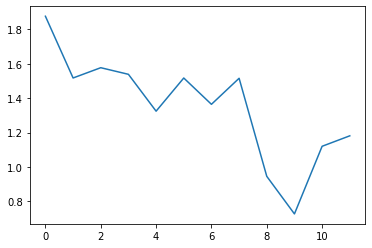

In [ ]:
plot_learning_curve(losses)

[[0.40679636 0.05780431 0.09709567 0.05219425 0.06154349 0.04670177
  0.02962857 0.06102089 0.11965874 0.06755595]
 [0.05718611 0.41619102 0.05116145 0.05338266 0.04167818 0.04461952
  0.04468544 0.04971106 0.07990283 0.16148172]
 [0.07762609 0.04628125 0.27210315 0.10289176 0.14175648 0.10865773
  0.08803678 0.08095538 0.04150811 0.04018328]
 [0.04836684 0.05262915 0.09744694 0.26013382 0.08042369 0.17900263
  0.09941639 0.08029663 0.04770843 0.05457549]
 [0.04179653 0.03906255 0.14069183 0.0780387  0.32309686 0.08573148
  0.11744068 0.10164779 0.03619897 0.03629463]
 [0.0431935  0.04715831 0.09102996 0.17967746 0.07714867 0.30466556
  0.07668467 0.08955468 0.04876148 0.04212571]
 [0.03443665 0.04083349 0.11240824 0.11424129 0.12489851 0.08979016
  0.36163819 0.05633072 0.02459761 0.04082512]
 [0.05789897 0.04698647 0.08621466 0.07479298 0.10711778 0.08780383
  0.04954844 0.3919523  0.03691277 0.06077181]
 [0.14972617 0.07979012 0.04501263 0.04514454 0.0383317  0.04798058
  0.02790114

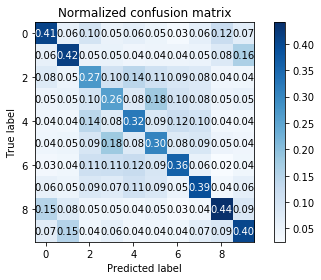

In [ ]:
plot_confusion_matrix()